**TV Series has always been a great source of entertainment. This is an EDA or a story telling through its data along with a content-based recommendation system and a wide range of different graphs and visuals.**

# If you find this Notebook Helpful, please upvote and comment the possible improvements 

# **TV Series Visualizations, Recommendation, EDA🍿**

Objective:
1. EDA
2. Content Based Recommender System

Importing the required Libraries

In [ ]:
import numpy as np 
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

Importing dataset

In [ ]:
data=pd.read_csv('/kaggle/input/tv-series-dataset/series_data.csv')

In [ ]:
data.head()

In [ ]:
data.dtypes

In [ ]:
data.info()

Lets sort the data based on No_of_Votes and IMDB_Ratings

In [ ]:
ratings=data.sort_values(['No_of_Votes'],ascending=False)
imdb=data.sort_values(['IMDB_Rating'],ascending=False)

Top Voted and Top Rated Series

In [ ]:
fig,axs=plt.subplots(figsize=(20,5))
g=sns.barplot(x=ratings['Series_Title'][:10],y=ratings['No_of_Votes'][:10])
g.set_title("Top Voted Series")
plt.show()
fig,axs=plt.subplots(figsize=(20,5))
g=sns.barplot(x=ratings['Series_Title'][:10],y=ratings['IMDB_Rating'][:10])
g.set_title("Top Rated Series")
plt.show()
plt.tight_layout()

Most Runtime_of_Series visualization

In [ ]:
fig,axs=plt.subplots(figsize=(20,5))
g=sns.barplot(x=data['Runtime_of_Series'].value_counts()[:10].index,y=data['Runtime_of_Series'].value_counts()[:10])
g.set_title("Runtime of Series")
g.set_xlabel("Years")
plt.show()

Calculation of the duration of a Series from Runtime_of_Series

In [ ]:
duration=[]
for x in data["Runtime_of_Series"]:
    p=re.compile('\d+')
    j=p.findall(x)
    if len(j)==2:
        duration.append(int(j[1])-int(j[0])+1)
    else:
        duration.append(2021-int(j[0])+1)
data['duration']=duration

KDE plot of duration calculated

In [ ]:
fig,axs=plt.subplots(figsize=(20,5))
g=sns.kdeplot(data['duration'])
g.set_title("Duration of series")

Counting the frequency of various certificates provided to these series

In [ ]:
#As there are a lots of NaN values in the Certificate Column, renaming it to 'Not Rated'
data['Certificate']=data['Certificate'].fillna('Not Rated')

#Visualizing all the certificates except 'Not Rated' category
ratings=data[data['Certificate']!='Not Rated']['Certificate']
fig,axs=plt.subplots(figsize=(20,5))
sns.set_style('darkgrid')
g=sns.countplot(ratings)
g.set_title("Count of Certificates provided")
plt.show()

Top ten Runtime_of_Episodes

In [ ]:
run_inmin=data['Runtime_of_Episodes'].apply(lambda x:str(x).split(" ")[0])
fig,axs=plt.subplots(figsize=(20,5))
g=sns.barplot(x=run_inmin.value_counts()[:10].index,y=run_inmin.value_counts()[:10])
g.set_xlabel("Duration of one Episode")
g.set_title("Top Ten Runtime of one Episode")
plt.show()

Most Common Genres of Series

In [ ]:
# Creating a list of all the Genres
genre=[]
for x in data['Genre']:
    for y in x.split(','):
        genre.append(y.strip().lower())
# Finding the Count of these Genres
count=Counter(genre)
count=count.most_common()[:10]
x,y=map(list,zip(*count))
# Visualizing the plot
fig,axs=plt.subplots(figsize=(20,5))
g=sns.barplot(y,x)
g.set_ylabel("Genres")
g.set_title("Top Ten Genres")
plt.show()

Word Cloud of the Genres

In [ ]:
from wordcloud import WordCloud
text=set(genre)
wordc=WordCloud(max_words=1500,background_color='black').generate(str(text))
fig,axs=plt.subplots(figsize=(20,20))
sns.set_style('dark')
plt.imshow(wordc)

Distribution of IMDb Ratings of the Series

In [ ]:
fig,axs=plt.subplots(figsize=(20,5))
g=sns.distplot(data['IMDB_Rating'],bins=30)
g.set_title("Distribution of Ratings")
plt.show()

Most Occurence of Stars

In [ ]:
stars=['Star1','Star2','Star3','Star4']
fig,axs=plt.subplots(4,1,figsize=(20,7))
ax=0
for x in stars:
    axs[ax].bar(data[x].value_counts()[:10].index,data[x].value_counts()[:10])
    axs[ax].set_title(x)
    axs[ax].set_ylabel("Appearances")
    ax+=1
    plt.tight_layout()

Stars of Top Voted Series

In [ ]:
stars=['Star1','Star2','Star3','Star4']
fig,axs=plt.subplots(4,1,figsize=(17,7))
ax=0
for x in stars:
    s=data.groupby([x]).sum().reset_index()
    d=s.sort_values(['No_of_Votes'],ascending=False)[:10]
    axs[ax].bar(d[x],d['No_of_Votes'])
    axs[ax].set_title(x)
    axs[ax].set_ylabel("Appearances")
    ax+=1
    plt.tight_layout()

Recommendation System (Content Based)¶

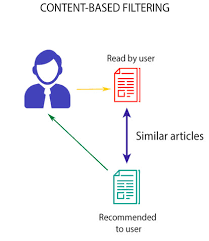

The TF-IDF(Term Frequency-Inverse Document Frequency (TF-IDF) ) score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

In [ ]:
#Importing TfidVectorizer and to generate the matrix
from sklearn.feature_extraction.text import TfidfVectorizer
cv=TfidfVectorizer(stop_words='english')
cvm=cv.fit_transform(data['Overview'])
cvm.shape

Here, The Cosine similarity score is used since it is independent of magnitude and is relatively easy and fast to calculate.
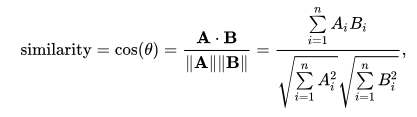

In [ ]:
#Importing linear_kernel to find the similarity of the data
from sklearn.metrics.pairwise import linear_kernel
sim=linear_kernel(cvm,cvm)

In [ ]:
indices=pd.Series(data.index,index=data['Series_Title']).drop_duplicates()

In [ ]:
def get_recommendations(title, sim=sim):
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return data['Series_Title'].iloc[movie_indices]

Lets check the results of the function

In [ ]:
get_recommendations('Friends')

In [ ]:
get_recommendations('Breaking Bad')

In [ ]:
get_recommendations('The Boys')

In [ ]:
get_recommendations('Sacred Games')

In [ ]:
get_recommendations('Tokyo Ghoul')